In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae

def pred_test_curve(y_test, y_pred, y_std=None):
    plt.figure(figsize=(16,7))
    plt.errorbar(y_test, y_pred, yerr=y_std, fmt='x', elinewidth=0.4)
    min_=np.min((y_test,y_pred))
    max_=np.max((y_test,y_pred))
    plt.xlabel('True Tc')
    plt.ylabel('Predicted Tc')
    plt.plot((min_,max_), (min_,max_), 'r--')
    plt.show()

    
def error_curve(y_test, y_pred, y_std):
    # sort indices from smallest to largest uncertainty
    y_std_sort = np.argsort(y_std)

    # sort indices from smallest to largest squared predictive error
    se_sort = np.argsort(((y_pred - y_test) ** 2))
    err, err_true = [], []
    for j in range(y_test.size, 0, -1):
        less_y_std = y_std_sort[:j]
        less_err = se_sort[:j]
        err.append(np.sqrt(mse(y_pred[less_y_std], y_test[less_y_std])))
        err_true.append(np.sqrt(mse(y_pred[less_err], y_test[less_err])))

    err=np.array(err)
    err_true=np.array(err_true)    

    plt.figure(figsize=(16,7))
    plt.plot(err, label = "Removing Most Uncertain")
    plt.plot(err_true, label = "Removing Largest Error")
    plt.xlabel('Points Removed')
    plt.ylabel('Error')
    plt.show()  

R2 Score: 0.9631
RMSE:     0.15946
MAE:     0.09393


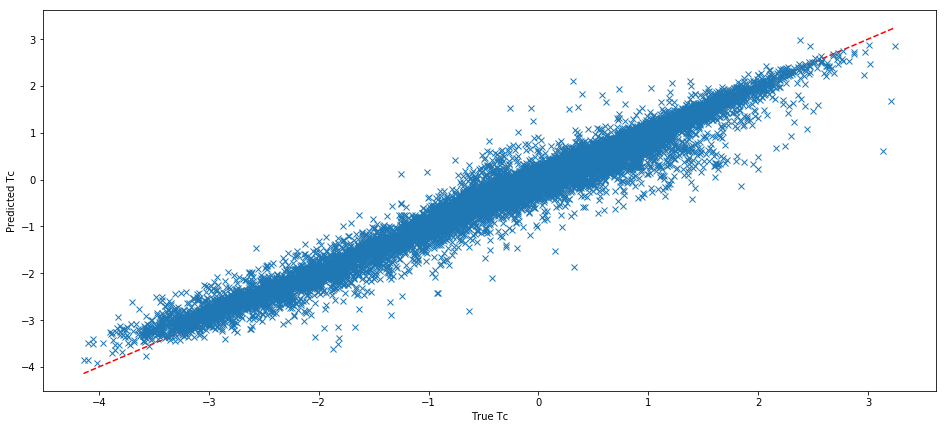

In [ ]:
data = np.loadtxt("/home/rhys/PhD/sampnn/test_results.csv", delimiter=",")
# y_test, y_pred, y_std = data[:,1], data[:,2], data[:,3]
y_test, y_pred = data[:,1], data[:,2]

print("R2 Score: {:.4f}".format(r2_score(y_test,y_pred)))
print("RMSE:     {:.5f}".format(np.sqrt(mse(y_test,y_pred))))
print("MAE:     {:.5f}".format(mae(y_test,y_pred)))

pred_test_curve(y_test, y_pred)    
y_std = np.zeros_like(y_pred)
# pred_test_curve(y_test, y_pred, y_std)    
error_curve(y_test, y_pred, y_std)

In [2]:
import magpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from forest import RandomForestRegressor as RFR

bandgap_dataset = pd.read_csv("/home/rhys/PhD/sampnn/data/datasets/stanev.csv")

idx, compositions, y = bandgap_dataset.T.values

embedding_file="/home/rhys/PhD/datasets/embeddings/onehot-embedding.json"
X = magpy.core.descriptors(compositions, embedding_file,
                            operations = ["wmean", "wstd", "max", "min"])

ln_y = np.log(y.astype(float))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=0)

y_test = np.exp(y_test)

rmse_list = []
r2_list = []
train_len_list = []

for n in [1,2,4,7,10,17]:
    X_train_n = X_train[0::n]
    y_train_n = y_train[0::n]
    
    train_len_list.append(len(X_train_n))
    
    # Scale the input features to improve
    scaler = StandardScaler().fit(X_train_n)
    X_train_n = scaler.transform(X_train_n) 
    X_test_n = scaler.transform(X_test) 

    reg = RFR(n_estimators=100).fit(X_train_n, y_train_n)
    y_pred, y_std = reg.predict(X_test_n, return_std=True)

    y_pred = np.exp(y_pred)
    y_std *= y_pred

    rmse = np.sqrt(mse(y_test,y_pred))
    rmse_list.append(rmse)
    
    r2 = r2_score(y_test,y_pred)
    r2_list.append(r2)
    
    print("Training Set Size: {}".format(len(X_train_n)))
    print("R2 Score: {:.4f}".format(r2))
    print("RMSE:     {:.5f}K\n".format(rmse))

    # pred_test_curve(y_test, y_pred, y_std)    
    # error_curve(y_test, y_pred, y_std)

Training Set Size: 4956
R2 Score: 0.8563
RMSE:     11.00405K

Training Set Size: 2478
R2 Score: 0.8199
RMSE:     12.31736K

Training Set Size: 1239
R2 Score: 0.7704
RMSE:     13.90802K

Training Set Size: 708
R2 Score: 0.7316
RMSE:     15.03583K

Training Set Size: 496
R2 Score: 0.7253
RMSE:     15.21315K

Training Set Size: 292
R2 Score: 0.6295
RMSE:     17.66737K



/home/rhys/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


10339.457147245957


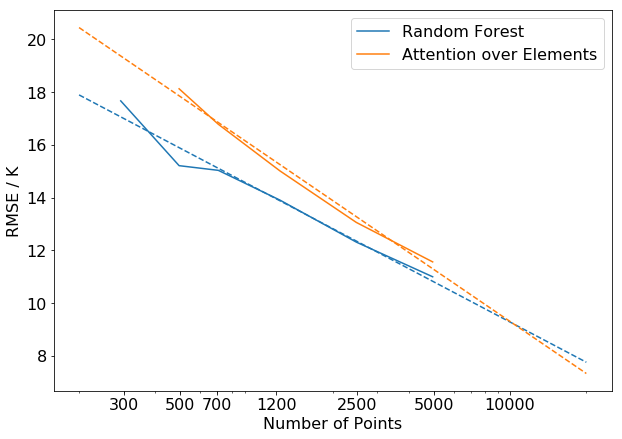

In [3]:
import matplotlib.ticker
from scipy import stats
plt.rcParams.update({'font.size': 16})


rmse_aoe = [11.56778, 13.06348, 15.01476, 16.78221, 18.12545]

slope_list, intercept_list, _, _, _ = stats.linregress(np.log(train_len_list), rmse_list)
slope_aoe, intercept_aoe, _, _, _ = stats.linregress(np.log(train_len_list[:len(rmse_aoe)]), rmse_aoe)

lim = np.array([200,20000])

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(train_len_list, rmse_list, label="Random Forest")
ax.plot(train_len_list[:len(rmse_aoe)], rmse_aoe, label="Attention over Elements")
ax.plot(lim,slope_list*np.log(lim) + intercept_list, '--', color='tab:blue')
ax.plot(lim,slope_aoe*np.log(lim) + intercept_aoe, '--', color='tab:orange')
ax.set_xscale('log')
ax.set_xticks([300,500, 700, 1200, 2500, 5000, 10000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel("Number of Points")
ax.set_ylabel("RMSE / K")
ax.legend()
fig.show()

fig.savefig("learning.pdf", bbox_inches='tight')

print(np.exp((intercept_aoe-intercept_list)/(slope_list-slope_aoe)))